# DBSCAN v2 with PCA-reduced features

In [9]:
import sys
sys.path.append("..")

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.cluster import calculate_k_distances, dbscan_kdist_analysis, \
    assign_dbscan_multidensity, dbscan_kdist_analysis_zoom

## Read in scaled features

In [2]:
df = pd.read_csv("../data/cohort_features_pca_v2.csv", index_col="ID")
df.head(5)

,PC1,PC2
ID,,
0,-8.616509,-0.329346
1,-9.616819,-0.435717
2,-9.331722,-3.538748
3,-9.757332,-0.521219
4,-7.608936,-3.519949


## Parameter exploration

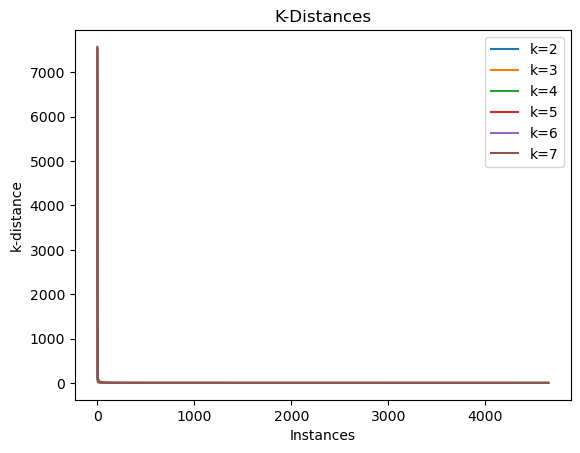

In [3]:
"""
Use k-distances to determine min_pts and eps
k = min_pts - 1
"""
k_list = [2, 3, 4, 5, 6, 7]
dbscan_kdist_analysis(args=(k_list, df))

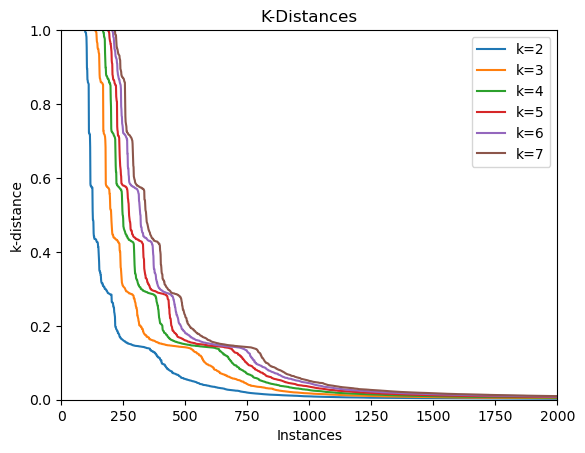

In [22]:
"""
Use k-distances to determine min_pts and eps
k = min_pts - 1
"""
k_list = [2, 3, 4, 5, 6, 7]
dbscan_kdist_analysis_zoom(args=(k_list, df, 2000, 1))

## Assign the clusters

In [57]:
# eps_list = [0.3, 1.8, 8, 18, 32, 58]
eps_list = [0.15]
k = 4
min_pts = k + 1

assigned_clusters = assign_dbscan_multidensity(args=(eps_list, min_pts, df.copy()))
assigned_clusters.to_csv(f"../data/cohort_clusters_dbscan_v2_pca.csv")
assigned_clusters

DBSCAN run:0 eps:0.15 n:4648


ID
0       1000
1       1000
2       1001
3       1000
4       1001
        ... 
4643    1000
4644    1000
4645    1000
4646    1000
4647    1000
Name: cluster, Length: 4648, dtype: int64

In [58]:
assigned_clusters.value_counts()

 1000    3099
 1001     801
-1        455
 1002      42
 1003      41
 1004      31
 1009      23
 1005      21
 1008      21
 1006      17
 1015      16
 1013      16
 1010      12
 1012      10
 1016       8
 1014       6
 1007       6
 1011       5
 1017       5
 1018       5
 1020       5
 1019       3
Name: cluster, dtype: int64

## Generate the COS

In [59]:
# Get the cluster label for COS
cos_label = assigned_clusters.value_counts().index[0]
cos_label

1000

In [60]:
df_cluster = pd.merge(left=df, right=assigned_clusters, on="ID")
cos = df_cluster[df_cluster["cluster"] == cos_label].drop(columns=["cluster"])
cos.to_csv("../data/cos_pca_dbscan_v2.csv")
cos

,PC1,PC2
ID,,
0,-8.616509,-0.329346
1,-9.616819,-0.435717
3,-9.757332,-0.521219
7,-8.902172,-0.435367
8,-7.900488,-0.451941
...,...,...
4643,-8.473257,-0.340542
4644,-8.473879,-0.469492
4645,-9.473750,-0.359499


## Visualise the clusters

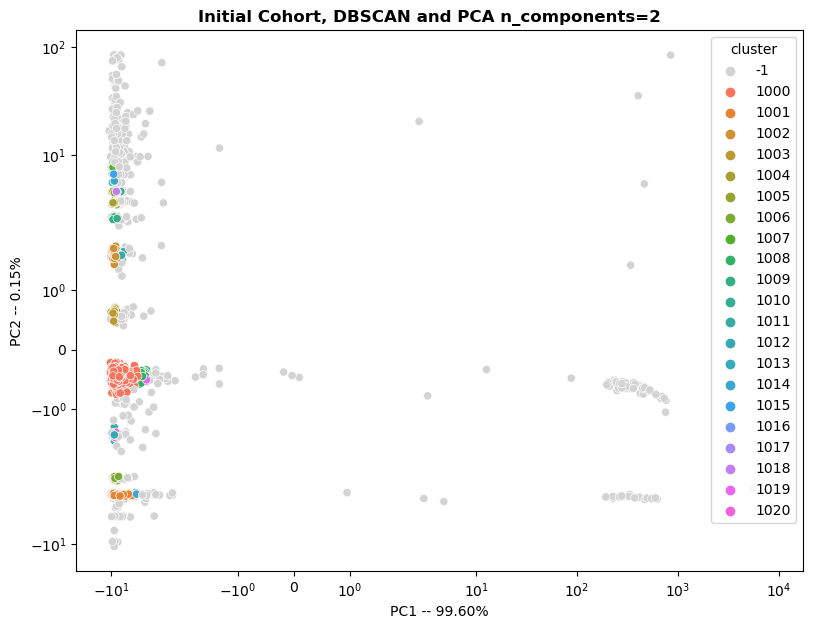

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

pal = sns.color_palette("husl", 24)
pal[0] = "lightgray"
sns.scatterplot(df_cluster, x="PC1", y="PC2", hue="cluster", ax=ax, palette=pal)

ax.set_xscale("symlog")
ax.set_yscale("symlog")
ax.set_xlabel(f"PC1 -- 99.60%")
ax.set_ylabel(f"PC2 -- 0.15%")

fig.suptitle("Initial Cohort, DBSCAN and PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

In [69]:
cos_los = pd.merge(
    left=cos,
    right=pd.read_csv("../data/cohort_labels_v2.csv", index_col="ID"),
    on="ID"
)
len(cos_los)

3099

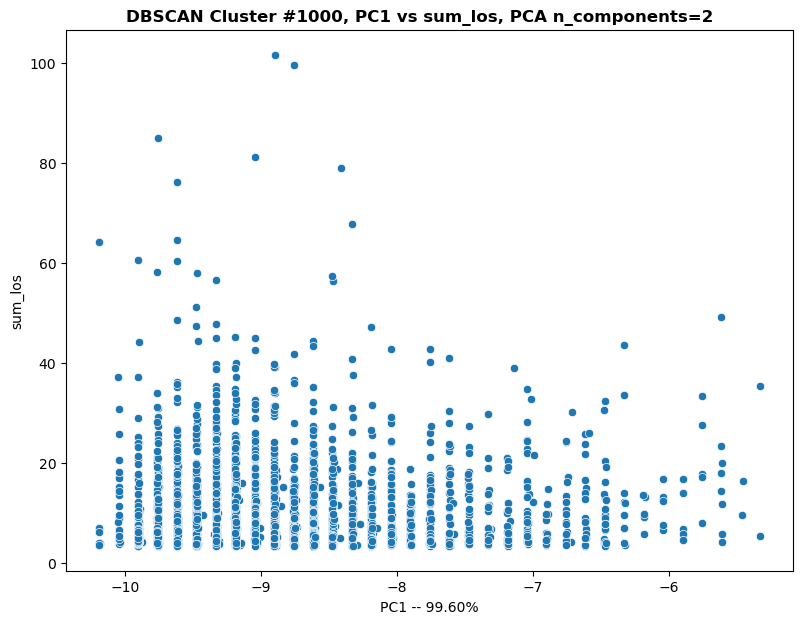

In [71]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(cos_los, x="PC1", y="sum_los", ax=ax)

# ax.set_xscale("symlog")
ax.set_xlabel(f"PC1 -- 99.60%")

fig.suptitle("DBSCAN Cluster #1000, PC1 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()

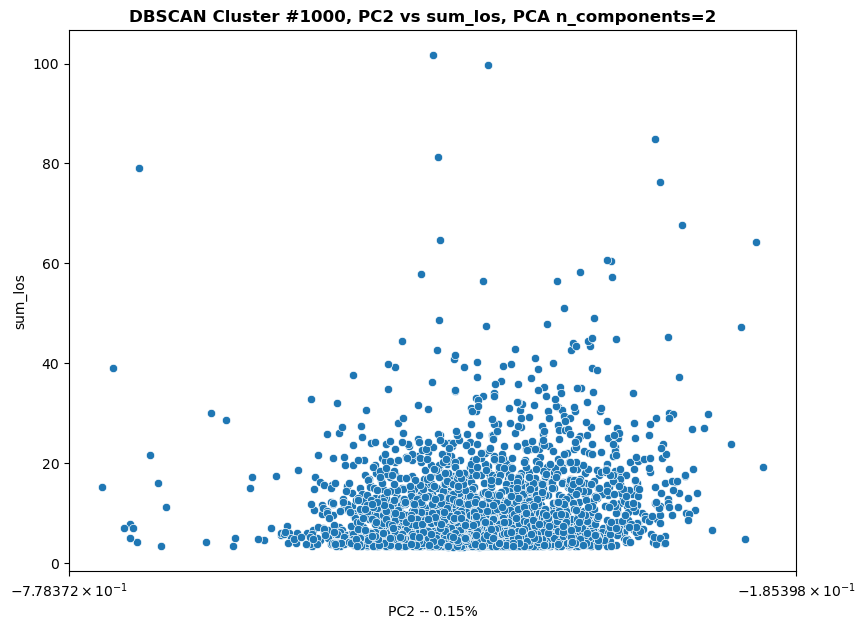

In [72]:
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
fig.tight_layout()

sns.scatterplot(cos_los, x="PC2", y="sum_los", ax=ax)

ax.set_xscale("symlog")
ax.set_xlabel(f"PC2 -- 0.15%")

fig.suptitle("DBSCAN Cluster #1000, PC2 vs sum_los, PCA n_components=2",
             fontweight="semibold", y=1.0)

plt.show()